<a href="https://colab.research.google.com/github/NumiKun/Dicoding_BPML/blob/main/Generative_AI_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

### Menentukan Hyperparameter yang akan Digunakan

In [2]:
latent_dim = 100
hidden_dim = 256
image_dim = 28 * 28
batch_size = 64
learning_rate = 0.0002
num_epochs = 50

### Memuat Dataset MNIST

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 476kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.93MB/s]


### Membuat Model GAN

#### Membuat sebuah kelas bernama Generator yang bertugas untuk membuat gambar baru berdasarkan data noise yang sudah dipelajari

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

#### Membuat Kelas Discriminator yang bertanggung jawab untuk mengambil gambar sebagai input dan menghasilkan skor yang menunjukkan seberapa asli gambar tersebut.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

### Melatih Model

#### Inisialisasi Kedua Kelas

In [6]:
generator = Generator()
discriminator = Discriminator()

#### Menentukan Optimizer dan Loss Function

In [7]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

# Loss function
adversarial_loss = nn.BCELoss()

#### Melatih Model

In [8]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        real_imgs = imgs

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

Epoch 1/50, D Loss: 0.010824709199368954, G Loss: 5.05318021774292
Epoch 2/50, D Loss: 0.049958132207393646, G Loss: 3.0561065673828125
Epoch 3/50, D Loss: 0.1729310303926468, G Loss: 1.6777158975601196
Epoch 4/50, D Loss: 0.09645968675613403, G Loss: 3.4007623195648193
Epoch 5/50, D Loss: 0.15701709687709808, G Loss: 2.6772425174713135
Epoch 6/50, D Loss: 0.013037851080298424, G Loss: 4.299259185791016
Epoch 7/50, D Loss: 0.03663591295480728, G Loss: 4.901187419891357
Epoch 8/50, D Loss: 0.13161906599998474, G Loss: 3.436420440673828
Epoch 9/50, D Loss: 0.10587286204099655, G Loss: 2.948991060256958
Epoch 10/50, D Loss: 0.1774098128080368, G Loss: 3.549661874771118
Epoch 11/50, D Loss: 0.11742401868104935, G Loss: 3.6745359897613525
Epoch 12/50, D Loss: 0.15955349802970886, G Loss: 5.08649206161499
Epoch 13/50, D Loss: 0.11078845709562302, G Loss: 5.082656383514404
Epoch 14/50, D Loss: 0.08673882484436035, G Loss: 3.442504405975342
Epoch 15/50, D Loss: 0.15209104120731354, G Loss: 7.2

### Membuat Gambar Baru dari Model

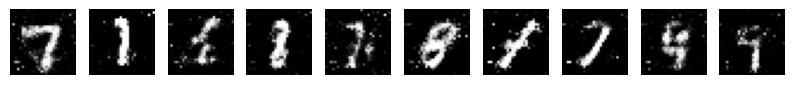

In [11]:
import matplotlib.pyplot as plt
# Generate new images
def generate_images(generator, num_images, latent_dim):
    # Menentukan status generator menjadi evaluation mode
    generator.eval()

    # Generate random noise
    z = torch.randn(num_images, latent_dim)

    # Generate images from noise
    gen_imgs = generator(z)

    # Rescale images menjadi rentang [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axs[i].imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Generate dan menampilkan 10 gambar baru
generate_images(generator, 10, latent_dim)